tuto : http://sebastianraschka.com/Articles/2014_pca_step_by_step.html

In [5]:
import numpy

In [3]:
# Open mesh in ply format
def open_ply(filepath):
    f=open(filepath,'r');
    i=0;
    ip=0;
    it=0;
    np=0;
    nt=0;
    for str in f:
        i+=1;
        arr=str.split(" ");
        if(arr[0]=="element" and arr[1]=="vertex"):
            np=int(arr[2]);
            p=numpy.zeros((np,3));
        elif(arr[0]=="element" and arr[1]=="face"):
            nt=int(arr[2]);
            t=numpy.zeros((nt,3));
        elif(i>=11 and i<11+np):
            p[ip,0]=float(arr[0]);
            p[ip,1]=float(arr[1]);
            p[ip,2]=float(arr[2]);
            ip+=1;
        elif(i>=11+np and i<11+np+nt):
            t[it,0]=int(arr[1]);
            t[it,1]=int(arr[2]);
            t[it,2]=int(arr[3]);
            it+=1;
    mesh={};
    mesh["np"]=np;
    mesh["nt"]=nt;
    mesh["p"]=p;
    mesh["t"]=t;
    return mesh;

In [6]:
pathDesktop = '/Users/ghfc/Desktop/'
fpoints = pathDesktop+'P32-F16_as_F01_402.ply'
mesh = open_ply(fpoints)
points=mesh["p"]

In [35]:
points.shape

(402, 3)

In [16]:
# Optional for plotting
# Load a txt file with the list of paired endpoints, such as each line has x y z of endpoint1 and x y z of endpoint2
fendpoints = pathDesktop+'P32_F16_endpoints_fit_paired.txt'
endpoints = np.loadtxt(fendpoints)

Populating the interactive namespace from numpy and matplotlib


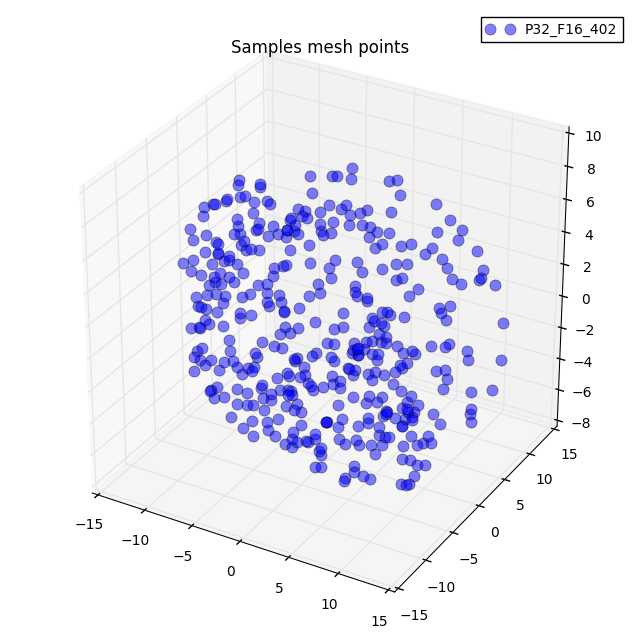

In [43]:
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(points[:,0], points[:,1], points[:,2], 'o', markersize=8, color='blue', alpha=0.5, label='P32_F16_402')
#ax.plot(endpoints[:,0], endpoints[:,1], endpoints[:,2], '.', markersize=8, color='red', alpha=0.5, label='P32_F16_endpoints')


plt.title('Samples mesh points')
ax.legend(loc='upper right')

plt.show()


In [7]:
points.shape

(402, 3)

In [9]:
# Mean Vector
mean_x = numpy.mean(points[:,0])
mean_y = numpy.mean(points[:,1])
mean_z = numpy.mean(points[:,2])

mean_vector = numpy.array([[mean_x],[mean_y],[mean_z]])

print 'Mean Vector:\n', mean_vector

Mean Vector:
[[-0.313867  ]
 [-0.3755523 ]
 [-0.12426812]]


In [23]:
# Covariance Matrix
cov_mat = np.cov([points[:,0],points[:,1],points[:,2]])
print 'Covariance Matrix:\n', cov_mat

Covariance Matrix:
[[ 53.55209197  -0.96195097  -5.81897622]
 [ -0.96195097  35.84299531   0.51274811]
 [ -5.81897622   0.51274811  17.6100168 ]]


In [24]:
# Eigenvectors - Eigenvalues

# eigenvectors and eigenvalues for the from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)

for i in range(len(eig_val_cov)):
    
    eigvec_cov = eig_vec_cov[:,i].reshape(1,3).T
    
    print 'Eigenvector {}: \n{}'.format(i+1, eigvec_cov) 
    print 'Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i])
    print 40 * '-' 


Eigenvector 1: 
[[ 0.98618824]
 [-0.05505954]
 [-0.15620883]]
Eigenvalue 1 from covariance matrix: 54.5275041871
----------------------------------------
Eigenvector 2: 
[[-0.15540419]
 [ 0.01863102]
 [-0.98767526]]
Eigenvalue 2 from covariance matrix: 16.6847670359
----------------------------------------
Eigenvector 3: 
[[-0.05729128]
 [-0.99830924]
 [-0.00981721]]
Eigenvalue 3 from covariance matrix: 35.7928328548
----------------------------------------


In [27]:
# Check eigenvector-eigenvalue calculation
# Σv=λv - covMat.eigenvectors = eigenvalues*eigenvectors ?

for i in range(len(eig_val_cov)):
    eigv = eig_vec_cov[:,i].reshape(1,3).T
    np.testing.assert_array_almost_equal(cov_mat.dot(eigv), eig_val_cov[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)

Populating the interactive namespace from numpy and matplotlib


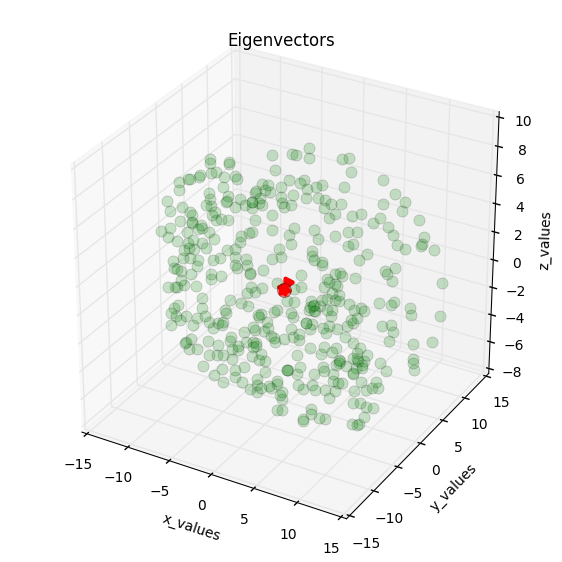

In [29]:
# Visualizing the eigenvectors

%pylab inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(points[:,0], points[:,1], points[:,2], 'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec_cov.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

In [32]:
# Sorting aignevectors by decreasing eigenvalues

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
    print(i[0])

54.5275041871
35.7928328548
16.6847670359


In [34]:
# Choosing eigenvectors
# the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop.

matrix_w = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))
print 'Matrix W:\n', matrix_w 

Matrix W:
[[ 0.98618824 -0.05729128]
 [-0.05505954 -0.99830924]
 [-0.15620883 -0.00981721]]


In [37]:
# Transforming the samples onto the new subspace

transformed = matrix_w.T.dot(points.T)
assert transformed.shape == (2,points.shape[0]), "The matrix has not the right dimensions."

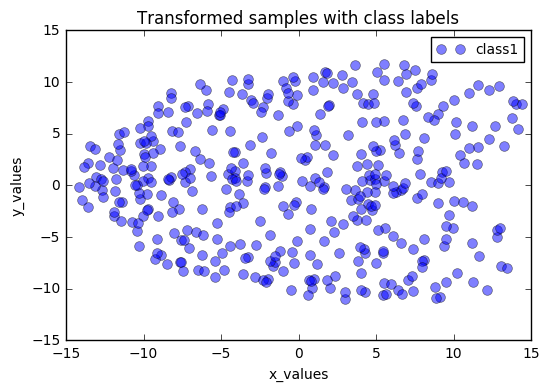

In [39]:
plt.plot(transformed[0,:], transformed[1,:], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
#plt.xlim([-4,4])
#plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.show()